In [8]:
# annotations denoting beats
BEAT_CLASSIFIERS = ["N","L","R","B","A","a","J","S","V","r","F","e","j","n","E","/","f","Q","?","|"]

qrs_window_size = 20 # even numbers, so QRS is centered!
net_window_size = 20
batch_size = 32

def extract_signals(record):
    channels = len(record.p_signal[0])
    signals = []
    for channel in range(channels):
        signals.append(record.p_signal[:,channel])
    return signals

def extract_annotations(annotations):
    """Removes first element which is begin marker."""
    positions = annotations.sample[1:]
    labels = annotations.symbol[1:]
    return positions, labels

def filter_annotations(positions, labels, keep):
    """
    Filter out all annotations not denoting beats.
    Keep beat classifiers and corresponding positions.
    """
    filtered_positions = [val for idx, val in enumerate(positions) if labels[idx] in keep]
    filtered_labels = [val for idx, val in enumerate(labels) if labels[idx] in keep]
    return filtered_positions, filtered_labels

In [9]:
import numpy as np
import wfdb

path = '../data/mit-bih-nsrdb/16265'
record = wfdb.rdrecord(path)
annotations = wfdb.rdann(path, 'atr')

signals = extract_signals(record)
signal = signals[0]

ann_positions, ann_labels = extract_annotations(annotations)
ann_positions, ann_labels = filter_annotations(ann_positions, ann_labels, BEAT_CLASSIFIERS)

## Normalize Signal

In [10]:
signal = (signal - min(signal)) / (max(signal) - min(signal))

## Generate QRS Stream

In [11]:
    qrs_stream = np.zeros(len(signal))

    for pos in ann_positions:
        pos_start = pos - qrs_window_size // 2
        pos_end = pos + qrs_window_size // 2
        qrs_stream[pos_start:pos_end] = 1.

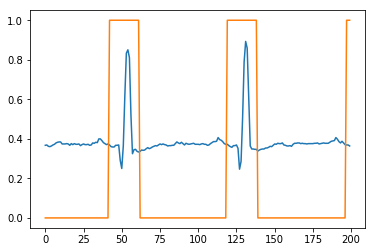

In [12]:
import matplotlib.pyplot as plt

plt.plot(signal[0:200])
plt.plot(qrs_stream[0:200])
plt.show()

## Define Data Generators

In [13]:
def generate_window(signal, qrs_stream, index, size, return_qrs=False):
    window = signal[index:index+size]
    label = qrs_stream[index + size // 2]
    if return_qrs:
        qrs_window = qrs_stream[index:index+size]
        return window, label, qrs_window
    return window, label

def generate_batch(signal, qrs_stream, window_size, batch_size):
    indexes = np.random.randint(low=0, high=len(signal)-window_size, size=batch_size)
    windows, labels = [], []
    for index in indexes:
        window, label = generate_window(signal, qrs_stream, index, window_size)
        windows.append(window)
        labels.append(label)
    return (
        np.array(windows),
        np.array(labels))

def batch_generator(signal, qrs_stream, window_size, batch_size):
    while True:
        yield generate_batch(signal, qrs_stream, window_size, batch_size)

QRS centered? --> 0.0


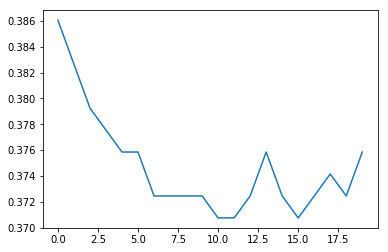

In [14]:
import matplotlib.pyplot as plt

for batch in batch_generator(signal, qrs_stream, net_window_size, 1):
    window = batch[0][0]
    label = batch[1][0]
    break

print("QRS centered? --> {}".format(label))
plt.plot(window)
plt.show()

## Train / Valid / Test Split

In [15]:
train_begin = 0
valid_begin = round(len(signal) * 0.6)
test_begin = round(len(signal) * 0.8)
end = len(signal)

train_gen = batch_generator(
    signal[train_begin:valid_begin],
    qrs_stream[train_begin:valid_begin],
    window_size = net_window_size,
    batch_size = batch_size)

valid_gen = batch_generator(
    signal[valid_begin:test_begin],
    qrs_stream[valid_begin:test_begin],
    window_size = net_window_size,
    batch_size = batch_size)

test_gen  = batch_generator(
    signal[test_begin:end],
    qrs_stream[test_begin:end],
    window_size = net_window_size,
    batch_size = batch_size)

## Build Neural Network

In [16]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(net_window_size, activation='relu', input_shape=(net_window_size,)))
model.add(Dense(2 * net_window_size, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 41        
Total params: 1,301
Trainable params: 1,301
Non-trainable params: 0
_________________________________________________________________


## Train Neural Network

In [17]:
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy'])

history = model.fit_generator(
    generator=train_gen,
    epochs=5,
    steps_per_epoch=1000,
    validation_data=valid_gen,
    validation_steps=100)

Epoch 1/5
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2211 - acc: 0.9173 - val_loss: 0.0363 - val_acc: 0.9897
Epoch 2/5
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0440 - acc: 0.9870 - val_loss: 0.0268 - val_acc: 0.9922
Epoch 3/5
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0307 - acc: 0.9898 - val_loss: 0.0249 - val_acc: 0.9916
Epoch 4/5
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0294 - acc: 0.9903 - val_loss: 0.0286 - val_acc: 0.9925
Epoch 5/5
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0246 - acc: 0.9915 - val_loss: 0.0281 - val_acc: 0.9912


## Eval

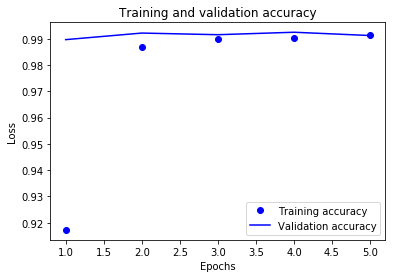

In [18]:
train_acc = history.history['acc']
valid_acc = history.history['val_acc']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, valid_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
x, y = [], []
for i in range(1,100):
    windows, labels = test_gen.__next__()
    x.extend(windows)
    y.extend(labels)

x = np.array(x)
y = np.array(y)
    
predictions = model.predict_classes(x, batch_size=batch_size)

Confusion matrix, without normalization
[[2975    3]
 [   5  185]]


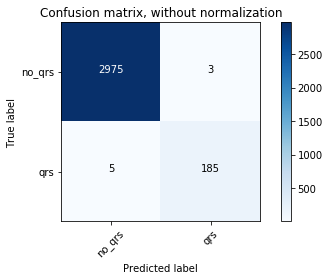

Normalized confusion matrix
[[0.99899261 0.00100739]
 [0.02631579 0.97368421]]


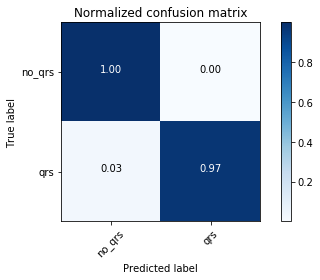

In [20]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
cm = confusion_matrix(y, predictions)

plt.figure()
plot_confusion_matrix(cm, classes=['no_qrs', 'qrs'], title='Confusion matrix, without normalization')
plt.show()

plt.figure()
plot_confusion_matrix(cm, classes=['no_qrs', 'qrs'], normalize=True, title='Normalized confusion matrix')
plt.show()